In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample()

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierBottomUpMAB.py', '../models/SimplifierBottomUpCMAB.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Bottom Up MAB', 'Bottom Up cMAB', 'Top Down', 'Without simplify', 'Top Down (only last)']
(76, 14)
['Bottom Up' 'Bottom Up MAB' 'Bottom Up cMAB' 'Without simplify']
['Airfoil' 'Concrete' 'Energy Cooling']
[15, 25, 35, 45, 55, 65, 75, 85, 95, 100]


In [2]:
all_data = []
for i, row in results_df.iterrows():
    model, dataset, random_state = row.loc[['model', 'dataset', 'random_state']]

    files = glob(f"{results_path}/{dnames_to_ugly[dataset]}/{nice_to_ugly[model]}/"
                f"*{random_state}_evolution.csv")

    for file in files:
        data = pd.read_csv(file)
        
        for gen in gens:
            try:
                row = data[data['gen']==gen].iloc[0] # should have just 1 row
            except Exception as e:
                print(e)
                # print(file, gen)
                # print(row)
                continue
            
            all_data.append((model, dataset, *row))
            
all_data_df = pd.DataFrame(all_data, 
                           columns=(
                               'model',
                               'dataset',
                               *row.index
                           ))

all_data_df = all_data_df.replace([np.inf, -np.inf], np.nan).dropna()

print(all_data_df.shape)
print(all_data_df['model'].unique())
print(all_data_df['dataset'].unique())
all_data_df.sample(5)

(732, 27)
['Bottom Up' 'Bottom Up MAB' 'Bottom Up cMAB' 'Without simplify']
['Airfoil' 'Concrete' 'Energy Cooling']


,model,dataset,gen,evals,best_size,n_simplifications,n_new_hashes,avg train error,avg train size,avg val error,...,std val error,std val size,min train error,min train size,min val error,min val size,max train error,max train size,max val error,max val size
756,Without simplify,Energy Cooling,75.0,40.0,22.0,0.0,0.0,47.413235,22.000,49.389392,...,3.552714e-14,0.000000,47.413235,22.0,49.389392,22.0,47.413235,22.0,49.389392,22.0
695,Without simplify,Concrete,65.0,40.0,22.0,0.0,0.0,235.527969,22.000,208.270216,...,4.543387e+02,0.000000,126.548189,22.0,124.937092,22.0,3849.946134,22.0,3045.316822,22.0
308,Without simplify,Airfoil,95.0,40.0,30.0,0.0,0.0,25.827354,27.925,24.168474,...,1.674831e+00,1.104253,24.358405,27.0,21.962930,27.0,26.870267,30.0,25.606795,30.0
542,Bottom Up MAB,Concrete,35.0,40.0,19.0,19.0,61.0,211.386623,19.350,200.749964,...,7.191576e-02,0.726292,211.379153,19.0,200.738448,19.0,211.677956,21.0,201.199078,21.0
702,Without simplify,Concrete,35.0,40.0,37.0,0.0,0.0,192.262171,37.375,204.218971,...,7.535014e+00,1.607599,175.904417,33.0,177.757016,33.0,193.663335,40.0,206.519115,40.0


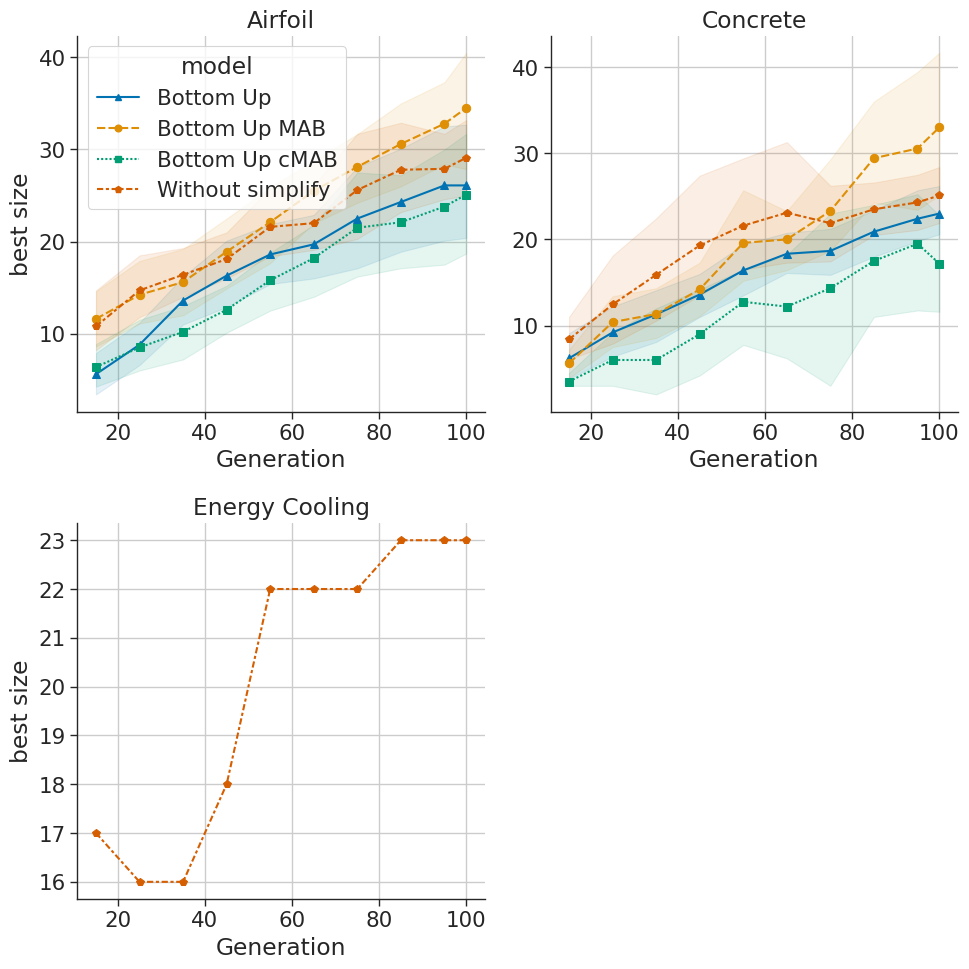

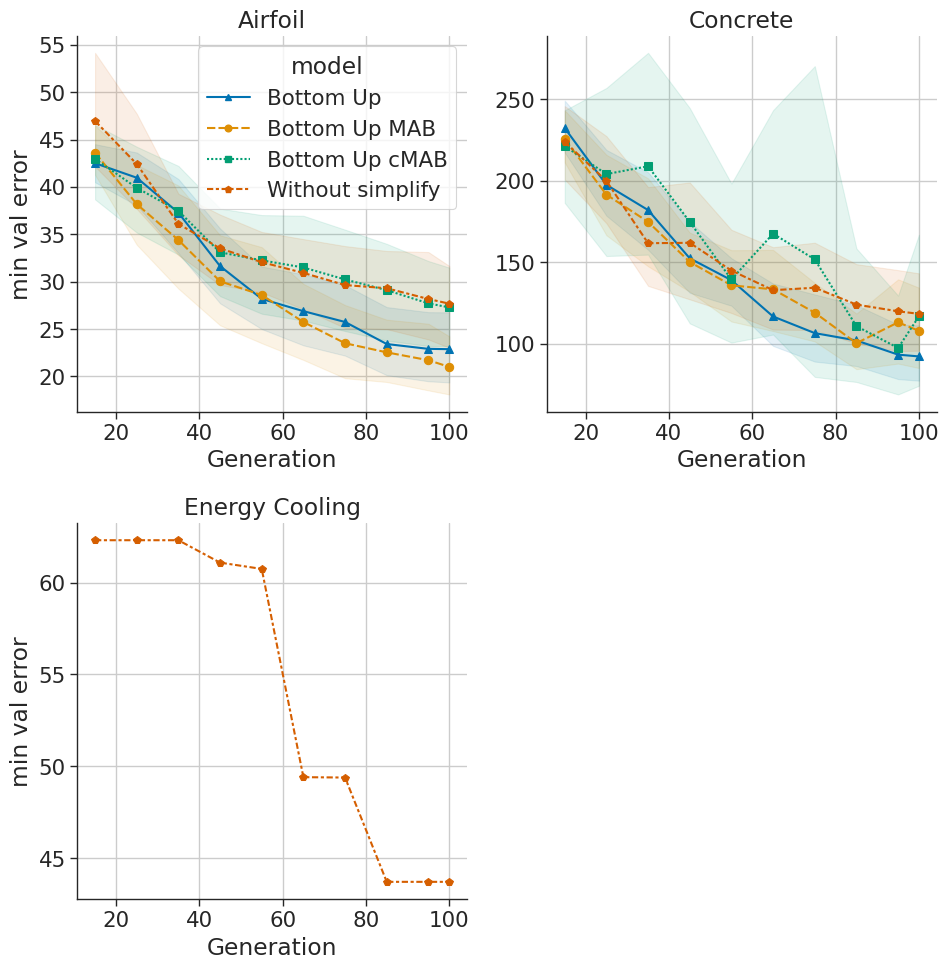

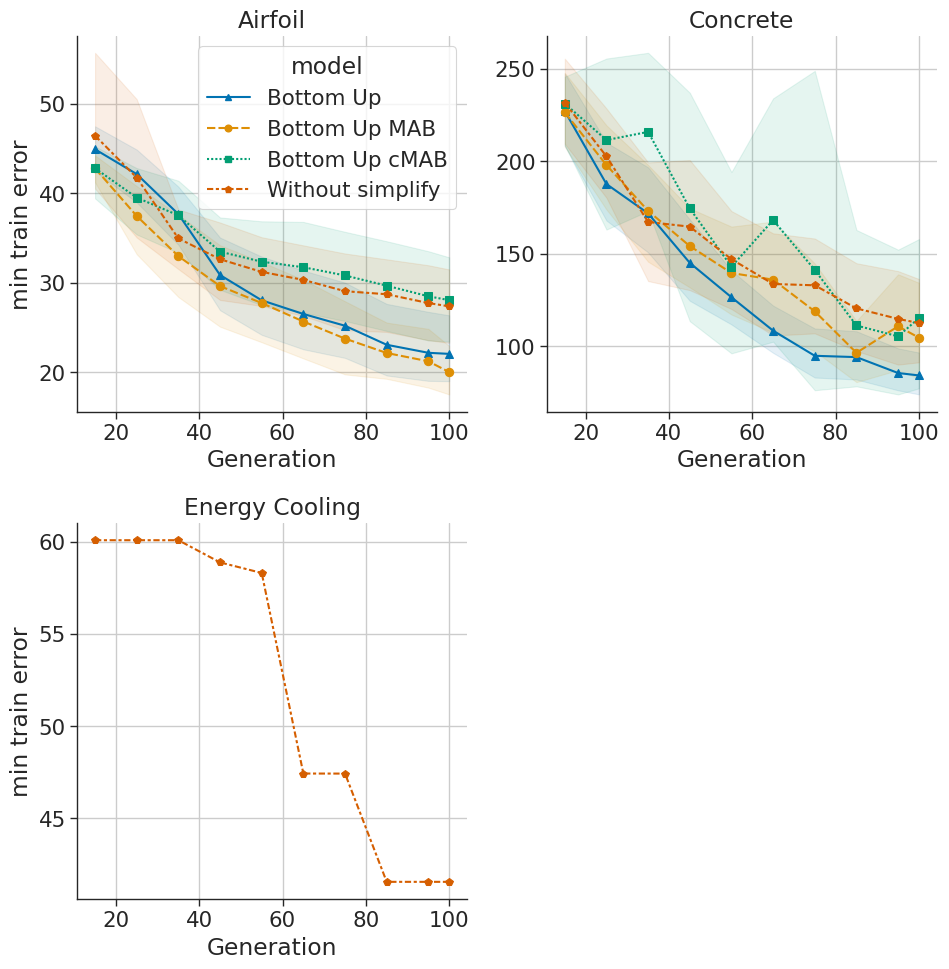

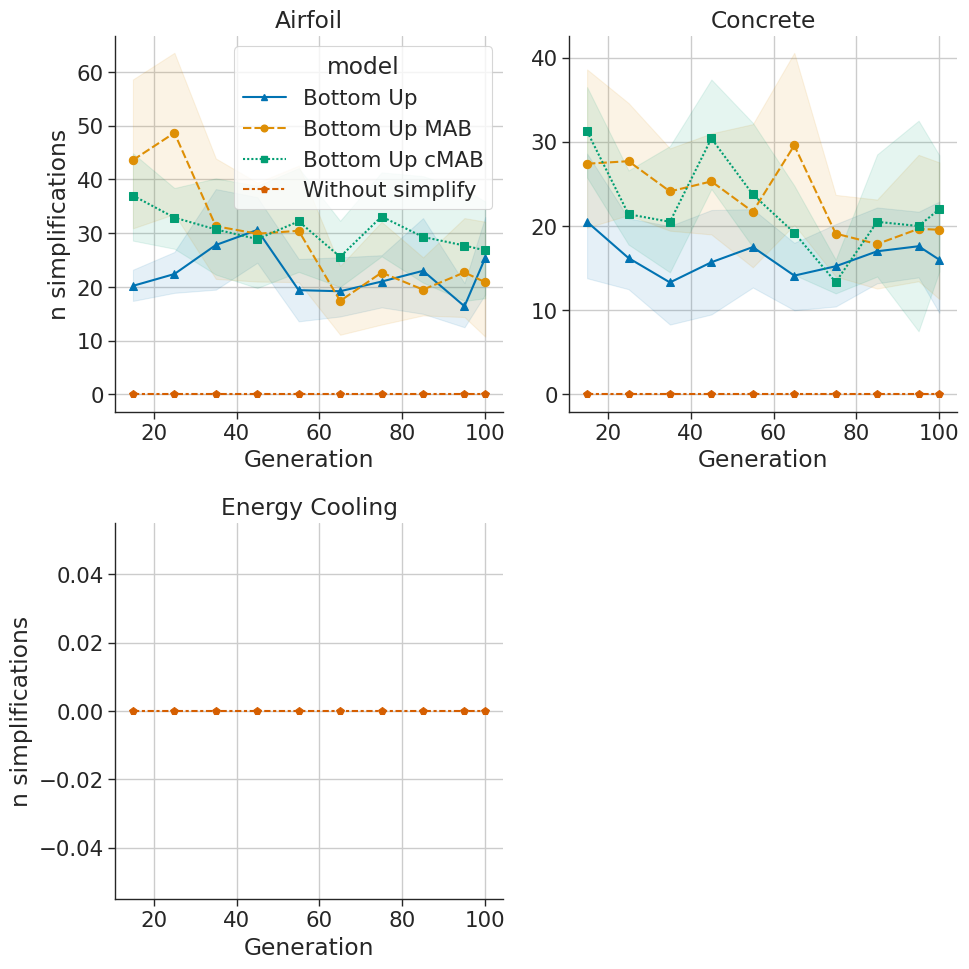

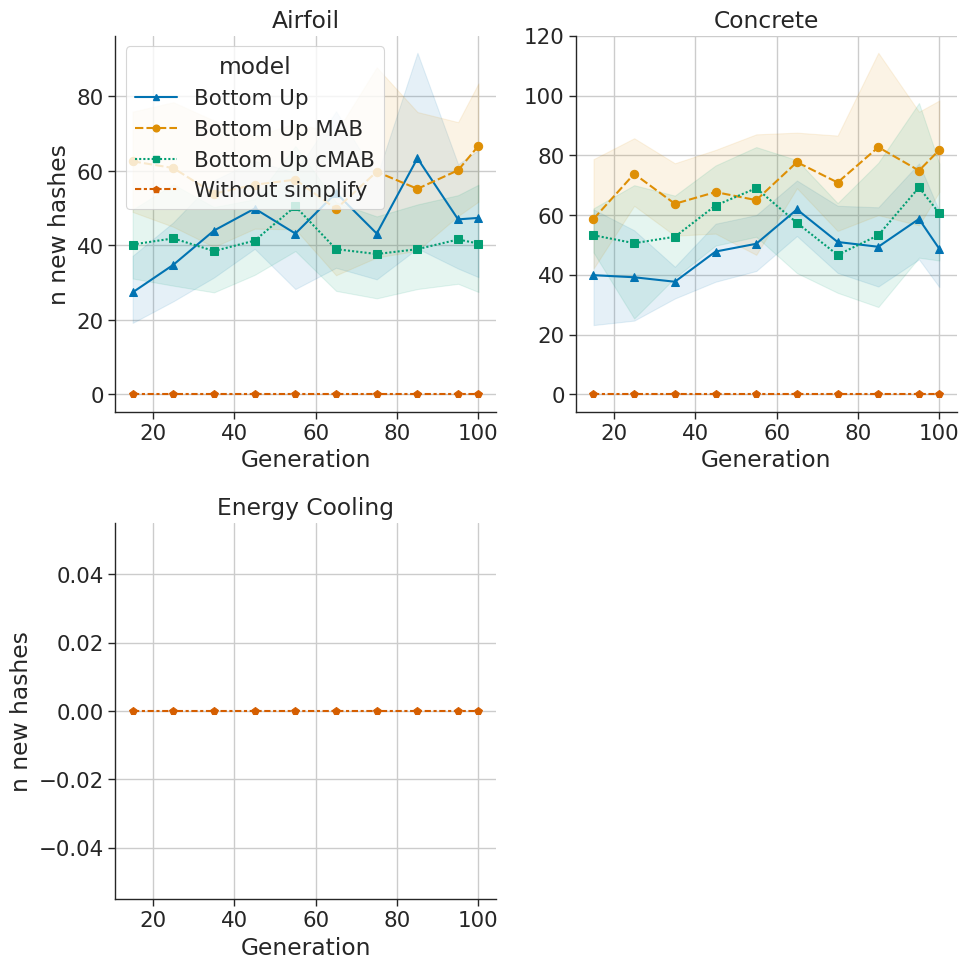

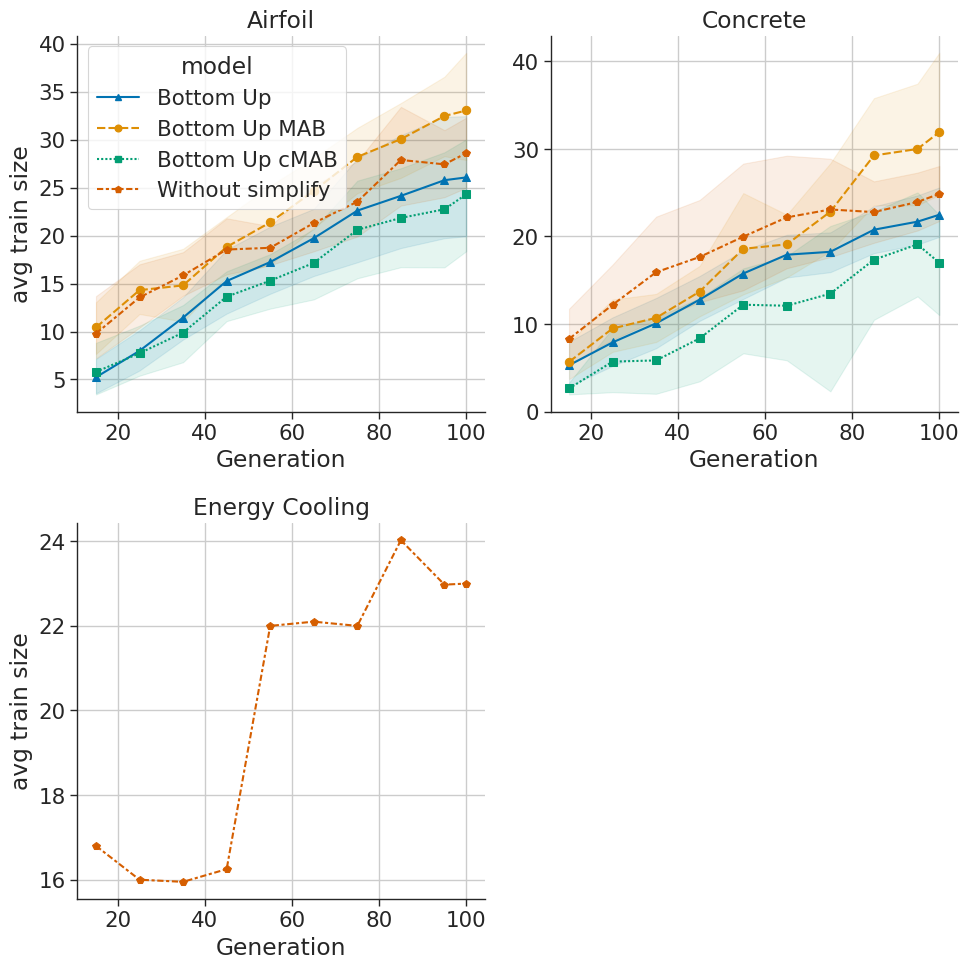

In [3]:
for col in [
    'best_size','min val error', 'min train error',
    'n_simplifications', 'n_new_hashes','avg train size',
    #'med train error','med val error',
]:
    
    # about errors: https://seaborn.pydata.org/tutorial/error_bars.html
    g = sns.relplot(
        data=all_data_df,
        x="gen", y=col, col="dataset", hue="model",
        style="model", col_wrap=col_wrap, markers=marker_choice, markeredgecolor=None, 
        kind="line", facet_kws={'sharey': False, 'sharex': False, 'legend_out':False}, 
        hue_order = order, estimator=np.mean, markersize=6,
        
        #err_style='bars', err_kws={'capsize':0.0, 'linewidth':0.0},
        #err_style='bars', err_kws={'capsize':2.0, 'linewidth':0.5}, # 2.0, 0.5
        err_style='band', err_kws={'alpha':0.1},
    )
    g.set_titles("{col_name}")

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='both', linewidth=1)
        plot_ax.set_xlabel("Generation")
        plot_ax.set_ylabel(plot_ax.get_ylabel().replace('_', ' '))

    if False: # use log scale
        #g.set(xscale="log")
        g.set(yscale="log")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{col}.pdf")
    plt.savefig(f"../paper/figs/{col}.png")
    plt.show()
    